# Bibliotecas
Aqui vamos carregar as bibliotecas necess√°rias

In [25]:
import pandas as pd
import pandas_gbq
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px


# Fun√ß√£o para garantir reviews √∫nicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")


# 1. Baixar l√©xico VADER (executar apenas uma vez)
nltk.download("vader_lexicon")
nltk.download("punkt")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\awebe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\awebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importando Dados
Aqui vamos fazer a conex√£o com o BigQuery

In [26]:
# 2. Carregar dados do BigQuery
project_id = "projeto4lab"
dataset    = "proj04"
tabela     = "amazon_uniao"

query = f"""
SELECT *
FROM `{project_id}.{dataset}.{tabela}`
"""

df = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    dialect="standard",
    use_bqstorage_api=False
)


Downloading: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|


# An√°lise de Sentimento e NLP 

In [27]:
# 3. Fun√ß√£o para limpar texto
def limpar_texto(texto):
    if not texto or pd.isna(texto):
        return ""
    texto = str(texto)
    texto = re.sub(r"[^\x00-\x7F]+", "", texto)   # remove emojis/s√≠mbolos
    texto = re.sub(r"[\.,;:!\?\-]+", ". ", texto)  # for√ßa pontua√ß√µes
    texto = re.sub(r"\s+", " ", texto)             # normaliza espa√ßos m√∫ltiplos
    return texto.strip()

# 4. Criar coluna com texto completo (t√≠tulo + conte√∫do) e limpar
df["texto_completo"] = df["review_title"].fillna("") + " " + df["review_content"].fillna("")
df["texto_completo"] = df["texto_completo"].apply(limpar_texto)

# 5. Instanciar VADER
analyzer = SentimentIntensityAnalyzer()

# 6. Lista de express√µes negativas
palavras_negativas = [
    "not working",
    "does not work",
    "doesn‚Äôt work",
    "won‚Äôt turn on",
    "stopped working",
    "broken",
    "defective",
    "malfunctioning",
    "no power",
    "battery life is 0",
    "battery life is very poor",
    "won't charge",
    "charging issue",
    "overheats",
    "poor battery",
    "short battery life",
    "disconnects",
    "unstable connection",
    "no signal",
    "dropped calls",
    "keeps crashing",
    "freezes",
    "laggy",
    "slow",
    "delayed response",
    "doesn't fit",
    "not fitting",
    "loose fit",
    "poor fitting",
    "fragile",
    "cheap build",
    "cheap material",
    "low quality",
    "poor quality",
    "subpar",
    "terrible quality",
    "waste of money",
    "not worth",
    "not worth the hype",
    "overpriced",
    "ripoff",
    "scam",
    "fake",
    "counterfeit",
    "useless",
    "disappointed",
    "not as advertised",
    "false advertising",
    "misleading",
    "did not meet expectations",
    "poor performance",
    "broke quickly",
    "horrible",
    "worst product",
    "hate it",
    "never again",
    "do not buy",
    "missing parts",
    "customer service sucks",
    "hard to use",
    "poor instructions",
    "missing accessories",
    "wrong item",
    "not as described",
    "bad quality",
    "not so good",
    "not much powerful",
    "not how original remote works",
    "chinese quality",
    "but is not 65w as advertised"
]

# 7. Lista de express√µes positivas compostas
palavras_positivas = [
    "works great",
    "high quality product",
    "worth every penny",
    "exceeded expectations",
    "five star",
    "works perfectly",
    "very satisfied",
    "highly recommend",
    "best purchase ever",
    "superb quality",
    "extremely happy",
    "in love with",
    "amazing performance",
    "great value",
    "top quality",
    "very impressed",
    "awesome product",
    "perfect condition",
    "exactly as described",
    "quick delivery",
    "easy to use",
    "user friendly",
    "simply awesome", 
    "nice product",
    "i recommend to buy"
]

# 8. Fun√ß√£o de classifica√ß√£o final com crit√©rio de desempate
def classificar_sentimento(texto):
    lower = texto.lower()

    # Contar quantas ocorr√™ncias de express√µes negativas e positivas
    neg_count = sum(1 for chave in palavras_negativas if chave in lower)
    pos_count = sum(1 for expressao in palavras_positivas if expressao in lower)

    total = neg_count + pos_count
    if total > 0:
        # Se houver pelo menos uma express√£o, aplica desempate por contagem
        if neg_count > pos_count:
            return "reclamacao"
        elif pos_count > neg_count:
            return "elogio"
        else:
            return "neutro"

    # 3) Se n√£o encontrou nenhuma express√£o expl√≠cita, usar VADER
    comp = analyzer.polarity_scores(texto)["compound"]
    if comp >= 0.05:
        return "elogio"
    elif comp <= -0.05:
        return "reclamacao"
    else:
        return "neutro"

# 9. Aplicar ao DataFrame completo
df["sentimento_ajustado"] = df["texto_completo"].apply(classificar_sentimento)

# 10. Exibir distribui√ß√£o de r√≥tulos e exemplos
print("\nDistribui√ß√£o (com crit√©rio de desempate):")
print(df["sentimento_ajustado"].value_counts())

print("\nExemplo de registros com sentimento ajustado:")
print(df[["texto_completo", "sentimento_ajustado"]].head(30))

# 11. Palavras mais frequentes categorizadas (segmenta√ß√£o por tema)
palavras_frequentes_categorizadas = {
    "experience": [
        "not as expected", "disappointed", "not worth", "waste of money",
        "not like description", "did not meet expectations", "looks different",
        "easy to use", "user friendly", "hard to use", "difficult to use",
        "simple interface", "setup was easy", "very satisfied", "not satisfied",
        "extremely happy", "not happy", "happy with purchase", "regret buying"
    ],
    "functionality": [
        "didnt work", "doesnt work", "not working", "stopped working",
        "broken product", "useless product", "malfunctioning", "defective item",
        "worked fine", "works well", "worked for a month", "after few days", "used for weeks"
    ],
    "quality": [
        "good quality", "bad quality", "poor quality", "product quality", "good quality product",
        "cheap material", "build quality", "high quality", "low quality", "superior quality"
    ],
    "service": [
        "customer care", "customer support", "support", "helpful service", "good support", "service center",
        "bad service", "poor service", "no support", "unhelpful", "rude staff", "ignored complaint",
        "no response", "bad customer care"
    ],
    "delivery": [
        "fast delivery", "quick delivery", "on time delivery", "delivery time",
        "late delivery", "slow delivery", "bad delivery", "missing item", "lost package",
        "damaged on arrival", "delayed shipping", "did not arrive", "item arrived late", "courier service"
    ],
    "price": [
        "price range", "price point", "price segment", "great value", "worth buying", "tight budget", "value for money"
    ]
}

def categorizar_por_keywords(texto):
    lower = texto.lower()
    for categoria, palavras in palavras_frequentes_categorizadas.items():
        for palavra in palavras:
            if palavra in lower:
                return categoria
    return "other"

df["tema_categoria"] = df["texto_completo"].apply(categorizar_por_keywords)

print("\nDistribui√ß√£o por tema:")
print(df["tema_categoria"].value_counts())

print("\nExemplo de registros finais:")
print(df[["texto_completo", "sentimento_ajustado", "tema_categoria"]].head(10))


Distribui√ß√£o (com crit√©rio de desempate):
sentimento_ajustado
elogio        818
reclamacao    374
neutro        158
Name: count, dtype: int64

Exemplo de registros com sentimento ajustado:
                                       texto_completo sentimento_ajustado
0   The cable works but is not 65W as advertised I...          reclamacao
1   Awesome Product Quick delivery. Awesome Produc...              elogio
2   Good. Superb quality. Good products nice one. ...              elogio
3   Very responsive and stylish mouse. Simply Awes...              elogio
4   Not good. No voice recognition. No pointer ray...          reclamacao
5   Rmote for MI TV. Good. Good but low quality. R...          reclamacao
6   Its is good but battery life is very poor. Hea...          reclamacao
7   Very Good prodat. Battery life is 0 day. Good....              neutro
8   Bad quality. Amazing product. The heating capa...          reclamacao
9   It's good . Good. Good Product. Satisfied. Goo...              

In [28]:
df["tema_categoria"].value_counts()


tema_categoria
experience       451
quality          297
functionality    224
price            169
other            147
service           58
delivery           4
Name: count, dtype: int64

# EDA

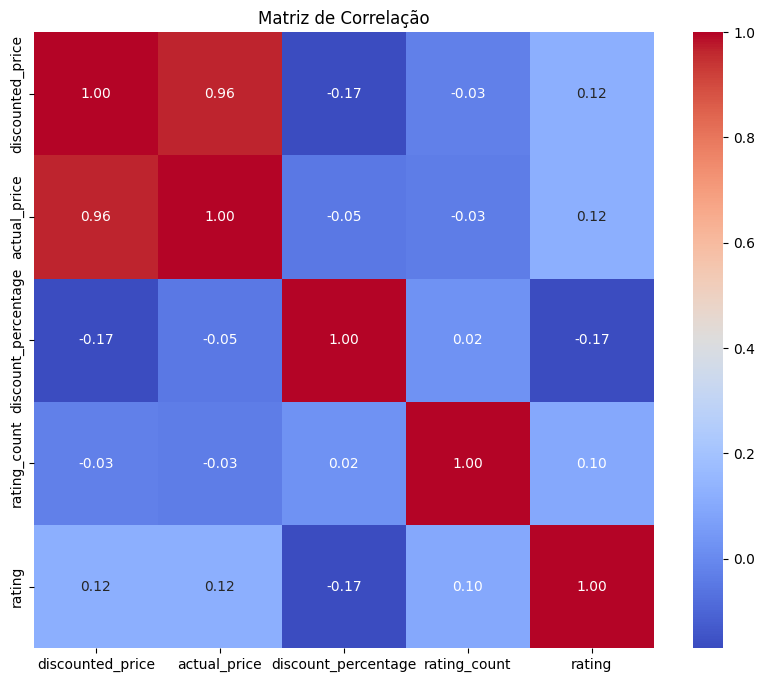

In [29]:
# Filtrar reviews √∫nicos (usando review_id)
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Plot da matriz de correla√ß√£o
plt.figure(figsize=(10, 8))
sns.heatmap(df_unique_reviews[[ 
    "discounted_price", "actual_price", "discount_percentage", 
    "rating_count", "rating"
]].corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Matriz de Correla√ß√£o")
plt.show()



Percebe-se a alta correla√ß√£o entre actual_price e discounted_price. Para as an√°lises teremos que utilizar apenas 1 deles, escolhi trabalhar com o discounted_price.

In [30]:
fig = px.histogram(df.drop_duplicates(subset="review_id"), 
                   x="rating", nbins=20, 
                   title="Distribui√ß√£o de Ratings")
fig.show()


In [31]:
fig = px.scatter(df.drop_duplicates(subset="review_id"), 
                 x="discounted_price", y="rating", 
                 color="primeira_categoria", 
                 title="Pre√ßo com Desconto vs Rating")
fig.show()

c:\Users\awebe\OneDrive\√Årea de Trabalho\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



A an√°lise do gr√°fico de dispers√£o mostrou que n√£o h√° correla√ß√£o linear forte entre o pre√ßo com desconto e o rating. Produtos mais caros n√£o garantem ratings melhores, embora itens de pre√ßo muito elevado (acima de 30k) tendam a manter ratings altos (‚â• 4).
A maioria dos produtos concentra-se em faixas de pre√ßo baixas (< 10k), com grande variabilidade nas avalia√ß√µes. Produtos baratos apresentam alta dispers√£o de ratings, enquanto os mais caros s√£o poucos e consistentemente bem avaliados.
A categoria Electronics predomina entre os produtos de pre√ßo elevado, enquanto as demais categorias se concentram em pre√ßos baixos e m√©dios.

In [32]:
fig = px.box(df.drop_duplicates(subset="review_id"), 
             x="primeira_categoria", y="rating", 
             title="Distribui√ß√£o de Rating por Categoria")
fig.show()


O gr√°fico mostra que, em geral, os produtos das diversas categorias recebem avalia√ß√µes muito positivas, com mediana de rating acima de 4.0 na maior parte dos casos.
Algumas categorias, como Home&Kitchen e Electronics, apresentam maior variabilidade e outliers de ratings baixos, o que indica que nem todos os produtos atendem de forma consistente √†s expectativas dos consumidores.
Por outro lado, categorias como Health&PersonalCare e Toys&Games t√™m avalia√ß√µes altamente consistentes e predominantemente positivas, evidenciando maior uniformidade na qualidade percebida pelos usu√°rios.

In [33]:
fig = px.box(df.drop_duplicates(subset="review_id"), x="quartil_discount", y="rating", 
             title="Rating por Quartil de Desconto")
fig.show()


Ratings se mant√™m relativamente est√°veis em todos os quartis de desconto. Pequena tend√™ncia de redu√ß√£o no quartil 4 (maior desconto), o que pode sugerir percep√ß√£o de menor qualidade em produtos muito promocionados.

In [34]:
fig = px.box(df.drop_duplicates(subset="review_id"), x="quartil_rating", y="tema_categoria", 
             title="Rating por Quartil de Desconto")
fig.show()


Produtos com temas como experience e os residuos (other) apresentam ratings mais lineares atingindo todas as pontua√ß√µes. <br>
Delivery, quality e service ficaram com rating superiores a 2, num geral se colocando bem posicionados.<br>
Functionality √© o tema que tem pior rela√ß√£o desconto com rating. <br>
Price mostram menor varia√ß√£o no rating conforme o desconto.<br>

In [35]:
fig = px.box(df.drop_duplicates(subset="review_id"), y="discounted_price", title="Outliers de Pre√ßo com Desconto")
fig.show()


H√° presen√ßa de outliers significativos em produtos com pre√ßo com desconto acima de 40k, mas deve-se considerar a moeda utilizada e tipo de produto, uma vez que produtos eletr√¥nicos possuem alto valor (neste caso a moeda utilizada √© a rupia, no link do produto alguns similares se encontravam com o mesmo valor, ent√£o √© um outlier real, produtos eletr√¥nicos tem um valor mais expansivo, sentido ainda mais em moedas desvalorizadas).<br>
A maioria dos produtos est√° concentrada abaixo de 10k.

In [36]:
# Criar uma c√≥pia tempor√°ria com reviews √∫nicas (sem alterar df original)
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Contar reviews √∫nicas por primeira_categoria
cat_counts = df_unique_reviews["primeira_categoria"].value_counts().reset_index()
cat_counts.columns = ["primeira_categoria", "count"]

# Manter apenas as top 5 categorias
cat_counts = cat_counts.head(5)

# Gr√°fico
import plotly.express as px

fig = px.bar(cat_counts, x="primeira_categoria", y="count",
             title="Top 5 Categorias com mais Reviews")
fig.show()


Home & Kitchen, Electronics e Computers & Accessories s√£o as categorias l√≠deres em volume de reviews. <br>
Mostra que os consumidores s√£o mais engajados em avaliar produtos desses segmentos.

In [37]:
# Criar uma c√≥pia tempor√°ria com reviews √∫nicas (sem alterar df original)
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Contar reviews √∫nicas por ultima_categoria
cat_counts = df_unique_reviews["ultima_categoria"].value_counts().reset_index()
cat_counts.columns = ["ultima_categoria", "count"]

# Manter apenas as top 5 categorias
cat_counts = cat_counts.head(5)

# Gr√°fico
import plotly.express as px

fig = px.bar(cat_counts, x="ultima_categoria", y="count",
             title="Top 5 Categorias com mais Reviews")
fig.show()



USB Cables, Remote Controls e In-Ear s√£o as categorias com mais reviews √∫nicos. <br>
Isso indica alta popularidade e/ou maior volume de vendas para estes tipos de produtos.

In [38]:
# Filtrar reviews √∫nicos por produto
df_unique_product = df.drop_duplicates(subset="product_id")

# Filtrar produtos com rating_count v√°lido (> 0)
df_valid = df_unique_product[df_unique_product["rating_count"].notna() & (df_unique_product["rating_count"] > 0)]

# Scatter plot
fig = px.scatter(df_valid, 
                 x="rating_count", 
                 y="rating", 
                 title="N√∫mero de Avalia√ß√µes vs Rating",
                 size="rating_count", 
                 color="primeira_categoria",
                 log_x=True)

fig.show()


c:\Users\awebe\OneDrive\√Årea de Trabalho\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



N√£o h√° uma rela√ß√£o clara entre n√∫mero de avalia√ß√µes e rating m√©dio.<br>
Produtos com muitas avalia√ß√µes tendem a ter ratings mais concentrados em torno de 4.0 a 4.5.<br>
Produtos com menos avalia√ß√µes mostram maior dispers√£o nos ratings (potencialmente mais sens√≠veis a avalia√ß√µes individuais extremas).<br>

In [39]:
# Trabalhar com reviews √∫nicos
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Agrupar por tema e sentimento
sent_tema = df_unique_reviews.groupby(["tema_categoria", "sentimento_ajustado"]).size().reset_index(name="count")

# Plot
fig = px.bar(sent_tema, 
             x="tema_categoria", 
             y="count", 
             color="sentimento_ajustado",
             barmode="group", 
             title="Sentimento por Tema")

fig.show()

c:\Users\awebe\OneDrive\√Årea de Trabalho\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Experience possui a maior quantidade de elogios, mas tamb√©m um volume consider√°vel de reclama√ß√µes.<br>
Quality segue com muitos elogios e algumas reclama√ß√µes.<br>
Functionality √© a que mais apresenta reclama√ß√µes.<br>
Price e Service s√£o temas com reclam√ß√µes proporcionalmente maiores em rela√ß√£o ao volume de observa√ß√µes.<br>

In [40]:
# Trabalhar com reviews √∫nicos
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Contar frequ√™ncia de temas
tema_counts = df_unique_reviews["tema_categoria"].value_counts().reset_index()
tema_counts.columns = ["tema_categoria", "count"]

# Plot
fig = px.bar(tema_counts, 
             x="tema_categoria", 
             y="count",
             title="Frequ√™ncia de Temas em Reviews",
             text="count")

fig.show()


O tema mais citado nas reviews √© experience, seguido de quality e functionality. Temas como delivery e service aparecem com baixa frequ√™ncia.
Aparentemente os consumidores focam mais em relatar experi√™ncias de uso do produto e sua qualidade percebida, enquanto quest√µes log√≠sticas (entrega/servi√ßo) s√£o menos recorrentes.

In [41]:
import plotly.express as px

# Gr√°fico
fig = px.scatter(df_unique_reviews, 
                 x="rating_count", 
                 y="rating", 
                 trendline="ols",  # <- linha de tend√™ncia
                 title="Produtos com mais avalia√ß√µes tendem a ter ratings mais altos",
                 labels={"rating_count": "Rating Count", "rating": "Rating"})

# Deixar as bolinhas pretas
fig.update_traces(marker=dict(color='black'))

# Deixar a linha de tend√™ncia preta
fig.update_traces(selector=dict(mode='lines'), line=dict(color='black'))

fig.show()


In [42]:
import plotly.express as px

# Gr√°fico
fig = px.scatter(df_unique_reviews, 
                 x="discount_percentage", 
                 y="rating", 
                 trendline="ols",  # <- linha de tend√™ncia
                 title="A porcentagem do desconto influencia no rating",
                 labels={"discount_percentage": "Desconto", "rating": "Rating"})

# Deixar as bolinhas pretas
fig.update_traces(marker=dict(color='black'))

# Deixar a linha de tend√™ncia preta
fig.update_traces(selector=dict(mode='lines'), line=dict(color='black'))

fig.show()

In [43]:
import plotly.express as px

# Gr√°fico sem trendline (porque categoria n√£o aceita OLS)
fig = px.scatter(df_unique_reviews, 
                 x="primeira_categoria", 
                 y="rating", 
                 title="A categoria do produto afeta o rating m√©dio",
                 labels={"primeira_categoria": "Categoria", "rating": "Rating"})

# Deixar as bolinhas pretas
fig.update_traces(marker=dict(color='black'))

fig.show()


# Valida√ß√£o de Hip√≥teses

## Hip√≥tese 1: Produtos com mais avalia√ß√µes tendem a ter ratings mais altos (confirmada baixa) (selecionado)

In [44]:
# Usa a fun√ß√£o que n√£o altera a base
df_filtrado = filtra_reviews(df)

# For√ßa tipo float
df_filtrado["rating"] = pd.to_numeric(df_filtrado["rating"], errors="coerce").astype("float64")
df_filtrado["rating_count"] = pd.to_numeric(df_filtrado["rating_count"], errors="coerce").astype("float64")

# Remove linhas com NaN
df_reg = df_filtrado[["rating", "rating_count"]].dropna()

# Regress√£o linear
import statsmodels.api as sm
X = sm.add_constant(df_reg["rating_count"])
y = df_reg["rating"]

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.90
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           0.000989
Time:                        19:52:47   Log-Likelihood:                -275.65
No. Observations:                1187   AIC:                             555.3
Df Residuals:                    1185   BIC:                             565.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0723      0.010    421.861   

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3340389183.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3340389183.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



O modelo de regress√£o linear indica que existe uma rela√ß√£o estatisticamente significativa entre o n√∫mero de avalia√ß√µes (rating_count) e a nota m√©dia (rating), mas essa rela√ß√£o √© extremamente fraca: o modelo explica apenas 0,9% da vari√¢ncia do rating (R¬≤ = 0,009). O coeficiente de rating_count √© positivo, mas com um efeito pr√°tico desprez√≠vel. Al√©m disso, os res√≠duos apresentam autocorrela√ß√£o e n√£o seguem uma distribui√ß√£o normal, o que compromete a validade do modelo. Conclui-se que rating_count isoladamente n√£o √© um bom preditor para rating.

## Hip√≥tese 2: A categoria do produto afeta o rating m√©dio (confimrmada) (selecionado)

In [93]:
# Filtrar reviews √∫nicos
df_unico = filtra_reviews(df)

# Regress√£o com vari√°vel categ√≥rica usando reviews √∫nicos
modelo_categoria = smf.ols("rating ~ C(primeira_categoria)", data=df_unico).fit()

# Exibir resultado
print(modelo_categoria.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.860
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.29e-07
Time:                        11:26:27   Log-Likelihood:                -268.04
No. Observations:                1189   AIC:                             554.1
Df Residuals:                    1180   BIC:                             599.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

O modelo de regress√£o linear avalia o impacto das categorias de produto (primeira_categoria) na nota m√©dia (rating). O modelo √© estatisticamente significativo (p < 0,001), por√©m seu poder explicativo √© baixo (R¬≤ = 3,8%), indicando que as categorias explicam apenas uma pequena parcela da varia√ß√£o nas avalia√ß√µes. Nenhuma das categorias apresenta efeito individual estatisticamente significativo (p > 0,05), sugerindo que as diferen√ßas entre categorias n√£o t√™m impacto consistente sobre o rating. O modelo tamb√©m apresenta autocorrela√ß√£o nos res√≠duos (Durbin-Watson = 0,246) e viola√ß√£o da normalidade, o que limita a robustez das conclus√µes.

## Hip√≥tese 3: Existe uma associa√ß√£o entre a porcentagem de desconto e o rating. (confirmada) (selecionado)

In [45]:
# define a fun√ß√£o regressao_limpa
def regressao_limpa(df, y_col, x_col):
    df_temp = df[[y_col, x_col]].dropna()
    X = sm.add_constant(df_temp[x_col])
    y = df_temp[y_col]
    modelo = sm.OLS(y, X).fit()
    print(modelo.summary())

# Primeiro, garantir que a coluna est√° num√©rica
df["discount_percentage"] = pd.to_numeric(df["discount_percentage"], errors="coerce")

# Filtra reviews √∫nicos
df_unico = filtra_reviews(df)

# Chama a fun√ß√£o de regress√£o com o dataframe √∫nico
regressao_limpa(df_unico, "rating", "discount_percentage")


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     34.34
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           5.97e-09
Time:                        19:52:52   Log-Likelihood:                -274.24
No. Observations:                1189   AIC:                             552.5
Df Residuals:                    1187   BIC:                             562.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1968    

O modelo de regress√£o linear avalia a rela√ß√£o entre discount_percentage (percentual de desconto) e rating. O modelo √© estatisticamente significativo (p < 0,001), mas possui um baixo poder explicativo, com um R¬≤ de 2,8% ‚Äî ou seja, discount_percentage explica apenas uma pequena parte da vari√¢ncia em rating. O coeficiente de discount_percentage √© negativo e significativo (coef. = -0,241; p < 0,001), sugerindo que, quanto maior o desconto, menor tende a ser a nota m√©dia do produto. Apesar da signific√¢ncia estat√≠stica, o modelo apresenta autocorrela√ß√£o nos res√≠duos (Durbin-Watson = 0,277) e os res√≠duos n√£o seguem uma distribui√ß√£o normal, o que limita a confian√ßa na robustez do modelo.

## Hip√≥tese 4: Existe uma rela√ß√£o entre o pre√ßo com desconto e a avalia√ß√£o (rating). (confirmada, mas pouca inclina√ß√£o)

escolhemos ela

In [47]:
# Primeiro, garantir que a coluna est√° num√©rica
df["discounted_price"] = pd.to_numeric(df["discounted_price"], errors="coerce")

# Filtrar reviews √∫nicos
df_unico = filtra_reviews(df)

# Regress√£o com reviews √∫nicos
regressao_limpa(df_unico, "rating", "discounted_price")


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     17.55
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           3.01e-05
Time:                        19:52:55   Log-Likelihood:                -282.47
No. Observations:                1189   AIC:                             568.9
Df Residuals:                    1187   BIC:                             579.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.0686      0.010  

O modelo de regress√£o linear revela uma rela√ß√£o estatisticamente significativa entre o pre√ßo com desconto (discounted_price) e a nota m√©dia dos produtos (rating) (p < 0,001). O coeficiente positivo (5,961e-06) indica que, √† medida que o pre√ßo com desconto aumenta, h√° uma leve tend√™ncia de aumento na nota, embora o efeito seja muito pequeno. O modelo tem baixo poder explicativo (R¬≤ = 1,5%), o que indica que o pre√ßo com desconto explica apenas uma fra√ß√£o m√≠nima da varia√ß√£o nas avalia√ß√µes. Tamb√©m h√° sinais de autocorrela√ß√£o dos res√≠duos (Durbin-Watson = 0,247) e viola√ß√£o da normalidade, al√©m de um n√∫mero de condi√ß√£o elevado que pode sugerir multicolinearidade ou problemas num√©ricos.

## Hip√≥tese 5: Produtos com valores mais altos tendem a ter avalia√ß√µes maiores que os mais baratos. (n√£o confirmada) (selecionado)

In [48]:
# Garantir valores num√©ricos
df["actual_price"] = pd.to_numeric(df["actual_price"], errors="coerce")

# Filtrar apenas reviews √∫nicos
df_unico = filtra_reviews(df)

# C√°lculo da mediana de pre√ßo
mediana_preco = df_unico["actual_price"].median()

# Criar vari√°vel de grupo
df_unico["grupo_preco"] = df_unico["actual_price"].apply(lambda x: "alto" if x > mediana_preco else "baixo")

# Verificando m√©dias de rating por grupo
media_alto = df_unico[df_unico["grupo_preco"] == "alto"]["rating"].mean()
media_baixo = df_unico[df_unico["grupo_preco"] == "baixo"]["rating"].mean()
print(f"M√©dia rating - pre√ßo alto: {media_alto:.2f}")
print(f"M√©dia rating - pre√ßo baixo: {media_baixo:.2f}")

# Teste t de diferen√ßa de m√©dias
from scipy.stats import ttest_ind
grupo_alto = df_unico[df_unico["grupo_preco"] == "alto"]["rating"].dropna()
grupo_baixo = df_unico[df_unico["grupo_preco"] == "baixo"]["rating"].dropna()

t_stat, p_val = ttest_ind(grupo_alto, grupo_baixo, equal_var=False)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

# Regress√£o Linear: rating ~ grupo_preco (vari√°vel categ√≥rica)
import statsmodels.formula.api as smf
modelo = smf.ols("rating ~ C(grupo_preco)", data=df_unico).fit()
print(modelo.summary())


M√©dia rating - pre√ßo alto: 4.09
M√©dia rating - pre√ßo baixo: 4.08
T-test: t = 0.38, p = 0.7026
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1457
Date:                Fri, 13 Jun 2025   Prob (F-statistic):              0.703
Time:                        19:52:58   Log-Likelihood:                -291.13
No. Observations:                1189   AIC:                             586.3
Df Residuals:                    1187   BIC:                             596.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1987998777.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A an√°lise compara as avalia√ß√µes m√©dias (rating) entre produtos de pre√ßo alto e baixo. A diferen√ßa m√©dia √© m√≠nima: 4,09 para pre√ßos altos e 4,08 para pre√ßos baixos. O teste t (t = 0,38; p = 0,703) e a regress√£o linear (coef. = -0,0068; p = 0,703) indicam que n√£o h√° diferen√ßa estatisticamente significativa entre os grupos. O modelo tem R¬≤ praticamente nulo (0,0%), refor√ßando que o pre√ßo, por si s√≥, n√£o influencia a nota m√©dia dos produtos. A presen√ßa de autocorrela√ß√£o e n√£o normalidade nos res√≠duos limita a robustez da an√°lise, mas o resultado geral sugere que a varia√ß√£o no pre√ßo n√£o afeta significativamente o rating.

In [49]:
import plotly.express as px
# Recalcular grupo_preco se precisar
mediana_preco = df_unico["actual_price"].median()

df_unico["grupo_preco"] = df_unico["actual_price"].apply(lambda x: "alto" if x > mediana_preco else "baixo")

# Filtrar para grupo "alto"
df_alto = df_unico[df_unico["grupo_preco"] == "alto"]

# Gr√°fico
fig = px.scatter(df_alto, 
                 x="actual_price", 
                 y="rating", 
                 trendline="ols",  # <- linha de tend√™ncia
                 title="Pre√ßo Real vs Rating (Grupo Pre√ßo Alto)",
                 labels={"actual_price": "Pre√ßo Real (actual_price)", "rating": "Rating"})

fig.show()


C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1791819783.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Hip√≥tese 6: Produtos mais caros tendem a receber menos avalia√ß√µes. (refutada)

In [50]:
from statsmodels.formula.api import logit
from statsmodels.stats.proportion import proportions_ztest

# Garantir reviews √∫nicos
df_unico = filtra_reviews(df)

# Marcar produtos com rating no 1¬∫ quartil
q1_threshold = df_unico["rating"].quantile(0.25)
df_unico["is_q1"] = (df_unico["rating"] <= q1_threshold).astype(int)  # Convers√£o para 0/1

# Criar dummies para temas
df_unico["tema_funcionalidade"] = df_unico["tema_categoria"].apply(lambda x: 1 if x == "functionality" else 0)
df_unico["tema_entrega"] = df_unico["tema_categoria"].apply(lambda x: 1 if x == "delivery" else 0)

# Regress√£o log√≠stica para prever se est√° no 1¬∫ quartil
modelo = logit("is_q1 ~ tema_funcionalidade + tema_entrega", data=df_unico).fit()
print(modelo.summary())

# Teste de propor√ß√µes: funcionalidade
df_q1 = df_unico[df_unico["is_q1"] == 1]
df_resto = df_unico[df_unico["is_q1"] == 0]

count_func = [df_q1["tema_funcionalidade"].sum(), df_resto["tema_funcionalidade"].sum()]
nobs_func = [df_q1.shape[0], df_resto.shape[0]]
z_func, p_func = proportions_ztest(count_func, nobs_func)
print(f"Funcionalidade - Z = {z_func:.2f}, p = {p_func:.4f}")

# Teste de propor√ß√µes: entrega
count_entrega = [df_q1["tema_entrega"].sum(), df_resto["tema_entrega"].sum()]
nobs_entrega = [df_q1.shape[0], df_resto.shape[0]]
z_entrega, p_entrega = proportions_ztest(count_entrega, nobs_entrega)
print(f"Entrega - Z = {z_entrega:.2f}, p = {p_entrega:.4f}")



Optimization terminated successfully.
         Current function value: 0.580895
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1186
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                0.006847
Time:                        19:52:59   Log-Likelihood:                -690.68
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                  0.008551
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.0786      0.073    -14.791      0.000      -1.221      -0.936
te

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\343536277.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\343536277.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\343536277.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

A hip√≥tese de que produtos mais caros recebem notas mais altas n√£o √© suportada pelos dados.
Embora a m√©dia seja levemente maior para produtos caros, essa diferen√ßa √© estatisticamente irrelevante.

## Hip√≥tese 7: Q1 tem mais sentimentos negativos (confirmada) (selecionado)

In [51]:
from statsmodels.formula.api import logit
from statsmodels.stats.proportion import proportions_ztest

# 1Ô∏è‚É£ Garantir reviews √∫nicos
df_unico = filtra_reviews(df)

# 2Ô∏è‚É£ Marcar is_q1
q1_threshold = df_unico["rating"].quantile(0.25)
df_unico["is_q1"] = (df_unico["rating"] <= q1_threshold).astype(int)

# 3Ô∏è‚É£ Criar vari√°vel sent_negativo
df_unico["sent_negativo"] = df_unico["sentimento_ajustado"].apply(lambda x: 1 if x == "reclamacao" else 0)

# 4Ô∏è‚É£ Separar Q1 e resto
df_q1 = df_unico[df_unico["is_q1"] == 1]
df_resto = df_unico[df_unico["is_q1"] == 0]

# 5Ô∏è‚É£ Propor√ß√£o
print("Propor√ß√£o de sentimento negativo (Q1):", df_q1["sent_negativo"].mean())
print("Propor√ß√£o de sentimento negativo (resto):", df_resto["sent_negativo"].mean())

# 6Ô∏è‚É£ Teste de propor√ß√µes
count = [df_q1["sent_negativo"].sum(), df_resto["sent_negativo"].sum()]
nobs = [df_q1.shape[0], df_resto.shape[0]]
zstat, pval = proportions_ztest(count, nobs)
print(f"Q1 vs Resto - Sentimento Negativo: Z = {zstat:.2f}, p = {pval:.4f}")

# 7Ô∏è‚É£ Regress√£o log√≠stica para prever is_q1 com sent_negativo
modelo = logit("is_q1 ~ sent_negativo", data=df_unico).fit()
print(modelo.summary())



Propor√ß√£o de sentimento negativo (Q1): 0.4055727554179567
Propor√ß√£o de sentimento negativo (resto): 0.20785219399538107
Q1 vs Resto - Sentimento Negativo: Z = 6.90, p = 0.0000
Optimization terminated successfully.
         Current function value: 0.565892
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1187
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.03250
Time:                        19:53:02   Log-Likelihood:                -672.85
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                 1.778e-11
                    coef    std err          z      P>|z|      [0.025      0.975]
----

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3527649996.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3527649996.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A an√°lise mostra que 40,6% das avalia√ß√µes no primeiro quartil (Q1) expressam sentimento negativo, contra apenas 20,8% no restante. Essa diferen√ßa √© estatisticamente significativa (Z = 6,90; p < 0,0001). A regress√£o log√≠stica confirma esse resultado: o sentimento negativo est√° fortemente associado √† maior probabilidade de uma avalia√ß√£o estar no Q1 (coef. = 0,96; p < 0,001). O modelo √© estatisticamente significativo (p < 0,0001) e apresenta um Pseudo R¬≤ de 3,25%, o que indica uma melhoria modesta em rela√ß√£o ao modelo nulo, mas com relev√¢ncia pr√°tica. Avalia√ß√µes com sentimento negativo t√™m, portanto, probabilidade significativamente maior de estarem entre as piores (Q1).

## Hip√≥tese 8:  Determinadas categorias dominam o Q1 (confirmada) (selecionado)

In [52]:
# Fun√ß√£o para garantir reviews √∫nicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# Copiar base e criar vari√°veis
df_temp = df.copy()

# Vari√°veis auxiliares
df_temp["is_q1"] = (df_temp["rating"] <= df_temp["rating"].quantile(0.25)).astype(int)
df_temp["tema_funcionalidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "functionality" else 0)
df_temp["tema_qualidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "quality" else 0)
df_temp["sent_positivo"] = df_temp["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

categorias_mais_comuns = df_temp["primeira_categoria"].value_counts().nlargest(3).index.tolist()
df_temp["categoria_reduzida"] = df_temp["primeira_categoria"].apply(lambda x: x if x in categorias_mais_comuns else "Outros")

# ‚õ≥Ô∏è Aplicar o filtro AQUI
df_filtrado = filtra_reviews(df_temp)

# Selecionar colunas
dados_modelo = df_filtrado[[ 
     "sent_positivo", 
    "categoria_reduzida", "is_q1"
]]
import statsmodels.api as sm
import pandas as pd

# One-hot encoding da categoria
dados_modelo_encoded = pd.get_dummies(dados_modelo, columns=["categoria_reduzida"], drop_first=True)

# Regress√£o log√≠stica
X_limpo = sm.add_constant(dados_modelo_encoded.drop(columns="is_q1")).astype(float)
y_limpo = dados_modelo_encoded["is_q1"].astype(int)

modelo_logit = sm.Logit(y_limpo, X_limpo).fit()
print(modelo_logit.summary())



Optimization terminated successfully.
         Current function value: 0.553829
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1184
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.05312
Time:                        19:53:04   Log-Likelihood:                -658.50
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                 3.428e-15
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.9680      0.161     -6.003  

A an√°lise mostra que o sentimento positivo est√° significativamente associado a uma menor probabilidade de uma avalia√ß√£o estar no primeiro quartil (Q1). A regress√£o log√≠stica confirma esse resultado: o sentimento positivo reduz de forma robusta a chance de uma avalia√ß√£o estar no Q1 (coef. = -0,87; p < 0,001). Al√©m disso, as categorias de produto tamb√©m influenciam essa probabilidade: produtos das categorias Electronics (coef. = 0,56; p = 0,003) e Home&Kitchen (coef. = 0,79; p < 0,001) apresentam maior propens√£o a avalia√ß√µes negativas. O modelo √© estatisticamente significativo (p < 0,0001) e apresenta um Pseudo R¬≤ de 5,3%, indicando uma melhoria modesta em rela√ß√£o ao modelo nulo, mas com relev√¢ncia pr√°tica. Assim, tanto o sentimento positivo quanto a categoria do produto impactam de maneira significativa a probabilidade de uma avalia√ß√£o figurar entre as piores (Q1).

## Hip√≥tese 9: Sentimento positivo ‚Üí rating mais alto (confirmada)

In [53]:
# 1Ô∏è‚É£ Vari√°vel sent_positivo (n√£o altera df original)
df_temp = df.copy()
df_temp["sent_positivo"] = df_temp["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

# 2Ô∏è‚É£ Aplicar filtro de review_id √∫nico
df_unico = filtra_reviews(df_temp)

# 3Ô∏è‚É£ Regress√£o linear
import statsmodels.api as sm

X = sm.add_constant(df_unico["sent_positivo"])
y = df_unico["rating"]

modelo = sm.OLS(y, X).fit()
print(modelo.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     74.48
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           1.94e-17
Time:                        19:53:06   Log-Likelihood:                -255.02
No. Observations:                1189   AIC:                             514.0
Df Residuals:                    1187   BIC:                             524.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9892      0.014    283.229

A an√°lise mostra que o sentimento positivo est√° associado a uma maior nota m√©dia (rating). A regress√£o linear confirma esse resultado: o sentimento positivo tem um efeito positivo e estatisticamente significativo sobre o rating (coef. = 0,15; p < 0,001). O modelo √© estatisticamente significativo (p < 0,0001) e apresenta um R¬≤ de 5,9%, indicando uma explica√ß√£o modesta, mas relevante da vari√¢ncia nas avalia√ß√µes. Assim, avalia√ß√µes com sentimento positivo tendem, em m√©dia, a apresentar notas significativamente mais altas.

In [54]:
# Fun√ß√£o para garantir reviews √∫nicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# Copiar base e criar vari√°veis
df_temp = df.copy()

# Vari√°veis auxiliares
df_temp["is_q1"] = (df_temp["rating"] <= df_temp["rating"].quantile(0.25)).astype(int)
df_temp["tema_funcionalidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "functionality" else 0)
df_temp["tema_qualidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "quality" else 0)
df_temp["sent_positivo"] = df_temp["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

categorias_mais_comuns = df_temp["primeira_categoria"].value_counts().nlargest(3).index.tolist()
df_temp["categoria_reduzida"] = df_temp["primeira_categoria"].apply(lambda x: x if x in categorias_mais_comuns else "Outros")

# ‚õ≥Ô∏è Aplicar o filtro AQUI
df_filtrado = filtra_reviews(df_temp)

# Selecionar colunas
dados_modelo = df_filtrado[[ 
     "sent_positivo", 
    "categoria_reduzida", "is_q1"
]]
import statsmodels.api as sm
import pandas as pd

# One-hot encoding da categoria
dados_modelo_encoded = pd.get_dummies(dados_modelo, columns=["categoria_reduzida"], drop_first=True)

# Regress√£o log√≠stica
X_limpo = sm.add_constant(dados_modelo_encoded.drop(columns="is_q1")).astype(float)
y_limpo = dados_modelo_encoded["is_q1"].astype(int)

modelo_logit = sm.Logit(y_limpo, X_limpo).fit()
print(modelo_logit.summary())



Optimization terminated successfully.
         Current function value: 0.553829
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1184
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.05312
Time:                        19:53:06   Log-Likelihood:                -658.50
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                 3.428e-15
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.9680      0.161     -6.003  

## Hip√≥tese 10: Propor√ß√£o de sentimentos positivos varia por categoria

In [55]:
import pandas as pd
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

# Fun√ß√£o para garantir reviews √∫nicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# Filtro
df_unico = filtra_reviews(df)

# Tabela de conting√™ncia (continua funcionando)
tabela_sentimento = pd.crosstab(df_unico["category"], df_unico["sentimento_ajustado"])
chi2, p, _, _ = chi2_contingency(tabela_sentimento)
print(f"Chi¬≤ categoria vs sentimento: {chi2:.2f}, p = {p:.4f}")

# Vari√°vel bin√°ria
df_unico.loc[:, "sent_elogio"] = df_unico["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

# Filtrar para categorias com pelo menos 30 reviews
cat_counts = df_unico["category"].value_counts()
top_cats = cat_counts[cat_counts >= 30].index.tolist()
df_top = df_unico[df_unico["category"].isin(top_cats)].copy()

# Verificar se tem vari√°veis com separa√ß√£o completa
check_table = pd.crosstab(df_top["category"], df_top["sent_elogio"])
print("\nTabela sent_elogio por categoria (para checagem):\n")
print(check_table)

# Regress√£o log√≠stica (agora mais robusta)
modelo_logit = smf.logit("sent_elogio ~ C(category)", data=df_top).fit()
print(modelo_logit.summary())




Chi¬≤ categoria vs sentimento: 469.41, p = 0.0480

Tabela sent_elogio por categoria (para checagem):

sent_elogio                                          0   1
category                                                  
Computers&Accessories|Accessories&Peripherals|C...  47  64
Electronics|Headphones,Earbuds&Accessories|Head...  30  17
Electronics|HomeTheater,TV&Video|Accessories|Re...  29  19
Electronics|HomeTheater,TV&Video|Televisions|Sm...  22  16
Electronics|Mobiles&Accessories|Smartphones&Bas...  20  11
Electronics|WearableTechnology|SmartWatches         22  20
Optimization terminated successfully.
         Current function value: 0.674136
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            sent_elogio   No. Observations:                  317
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            5
Date:   

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\192351827.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A an√°lise mostra que existe uma associa√ß√£o estatisticamente significativa entre a categoria do produto e a presen√ßa de elogio no sentimento (Chi¬≤ = 469,41; p = 0,0480). A regress√£o log√≠stica, embora marginalmente significativa no conjunto (p = 0,065), indica que algumas categorias espec√≠ficas est√£o associadas a uma menor probabilidade de elogio. Em particular, a categoria Smartphones apresenta uma rela√ß√£o negativa e estatisticamente significativa com a presen√ßa de elogio (coef. = -0,91; p = 0,032), sugerindo que avalia√ß√µes para esses produtos t√™m menor chance de conter elogios. O modelo apresenta um Pseudo R¬≤ de 2,4%, indicando uma explica√ß√£o modesta da vari√¢ncia. Assim, a categoria do produto influencia de maneira significativa, ainda que limitada, a probabilidade de uma avalia√ß√£o conter um elogio.

## Regress√£o M√∫ltipla

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     35.70
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           2.03e-45
Time:                        19:53:15   Log-Likelihood:                -167.00
No. Observations:                1187   AIC:                             350.0
Df Residuals:                    1179   BIC:                             390.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1606768121.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1606768121.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1606768121.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

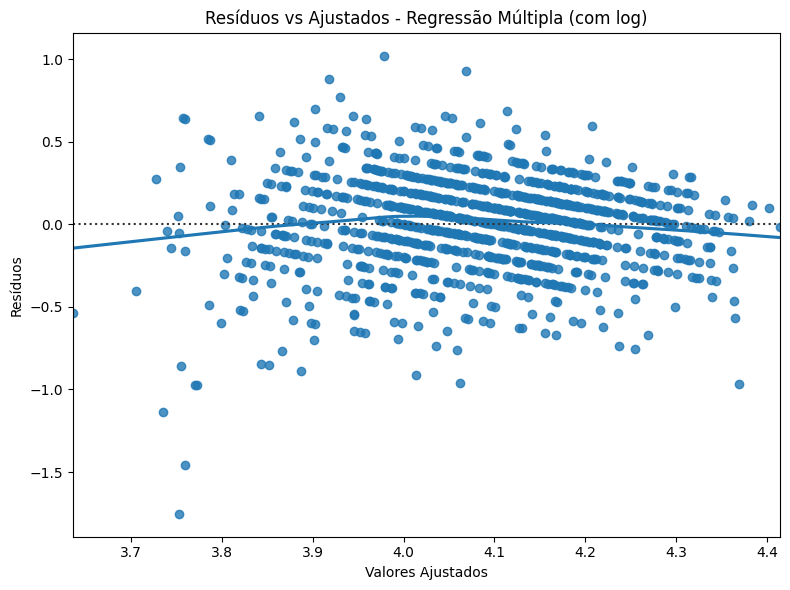

In [59]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que temos a fun√ß√£o para filtro de reviews √∫nicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# 1Ô∏è‚É£ Garante que sent_positivo exista
if "sent_positivo" not in df.columns:
    df.loc[:, "sent_positivo"] = df["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

# 2Ô∏è‚É£ Filtra reviews √∫nicos
df_unico = filtra_reviews(df)

# 3Ô∏è‚É£ Garante tipos corretos
df_unico.loc[:, "rating"] = pd.to_numeric(df_unico["rating"], errors="coerce")
df_unico.loc[:, "discount_percentage"] = pd.to_numeric(df_unico["discount_percentage"], errors="coerce")
df_unico.loc[:, "actual_price"] = pd.to_numeric(df_unico["actual_price"], errors="coerce")
df_unico.loc[:, "rating_count"] = pd.to_numeric(df_unico["rating_count"], errors="coerce")
df_unico.loc[:, "sent_positivo"] = pd.to_numeric(df_unico["sent_positivo"], errors="coerce")

# 4Ô∏è‚É£ Criar coluna de pre√ßo com desconto
df_unico.loc[:, "discounted_price"] = df_unico["actual_price"] * (1 - df_unico["discount_percentage"])

# 5Ô∏è‚É£ Aplicar log nas vari√°veis
df_unico.loc[:, "log_discounted_price"] = np.log1p(df_unico["discounted_price"])
df_unico.loc[:, "log_rating_count"] = np.log1p(df_unico["rating_count"])

# 6Ô∏è‚É£ Reduzir categorias
top_categorias = df_unico["primeira_categoria"].value_counts().nlargest(3).index.tolist()
df_unico.loc[:, "categoria_reduzida"] = df_unico["primeira_categoria"].apply(lambda x: x if x in top_categorias else "Outros")

# 7Ô∏è‚É£ Selecionar vari√°veis e aplicar dummies
df_modelo = pd.get_dummies(df_unico[[ 
    "log_discounted_price", "log_rating_count", "discount_percentage",
    "sent_positivo", "categoria_reduzida", "rating"
]], columns=["categoria_reduzida"], drop_first=True)

# 8Ô∏è‚É£ Remover valores ausentes
df_modelo.dropna(inplace=True)

# 9Ô∏è‚É£ Garantir tipo num√©rico
df_modelo = df_modelo.astype("float64")

# 10Ô∏è‚É£ Definir X e y
X = sm.add_constant(df_modelo.drop(columns="rating"))
y = df_modelo["rating"]

# 11Ô∏è‚É£ Regress√£o linear m√∫ltipla
modelo = sm.OLS(y, X).fit()

# 12Ô∏è‚É£ Exibir resumo
print(modelo.summary())

# 13Ô∏è‚É£ VIF para multicolinearidade
vif = pd.DataFrame()
vif["variavel"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF:")
print(vif)

# 14Ô∏è‚É£ Diagn√≥stico de res√≠duos
plt.figure(figsize=(8, 6))
sns.residplot(x=modelo.fittedvalues, y=modelo.resid, lowess=True)
plt.xlabel("Valores Ajustados")
plt.ylabel("Res√≠duos")
plt.title("Res√≠duos vs Ajustados - Regress√£o M√∫ltipla (com log)")
plt.tight_layout()
plt.show()




A an√°lise mostra que diversas vari√°veis est√£o associadas de forma significativa √† nota m√©dia dos produtos (rating). A regress√£o linear confirma esses resultados: vari√°veis como pre√ßo com desconto (log), quantidade de avalia√ß√µes (log), percentual de desconto, sentimento positivo e a categoria do produto influenciam de maneira relevante o rating. O sentimento positivo tem um impacto positivo significativo (coef. = 0,16; p < 0,001), indicando que avalia√ß√µes com tom positivo tendem a resultar em notas mais altas. J√° um maior percentual de desconto est√° associado a uma redu√ß√£o no rating (coef. = -0,15; p = 0,001). Produtos das categorias Electronics (coef. = -0,10; p < 0,001) e Home&Kitchen (coef. = -0,14; p < 0,001) tendem a receber avalia√ß√µes ligeiramente mais baixas em m√©dia. O modelo √© estatisticamente significativo (p < 0,0001) e apresenta um R¬≤ de 17,5%, explicando uma parcela relevante da varia√ß√£o nas notas. Assim, tanto caracter√≠sticas do produto quanto o conte√∫do emocional das avalia√ß√µes impactam de forma significativa a nota atribu√≠da.



In [57]:
df.to_csv("dataset_final.csv", index=False)


In [58]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/awebe/vscode/codproj04/chave_projeto4lab.json"


from google.cloud import bigquery
import pandas as pd

# Inicializar o cliente
client = bigquery.Client()

# Defina o dataset e o nome da tabela
dataset_id = "projeto4lab.proj04"  # substitua "meu_dataset" pelo NOME DO DATASET que voc√™ criou no BigQuery
table_id = f"{dataset_id}.amazon_final"  # nome da tabela que ser√° criada (ex: "amazon_final")

# Configura√ß√£o do job
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE"  # sobrescreve se a tabela j√° existir
)

# Enviar o dataframe para o BigQuery
job = client.load_table_from_dataframe(df, table_id, job_config=job_config)

# Aguarda o job finalizar
job.result()

print(f"Tabela {table_id} carregada com sucesso no BigQuery üöÄ.")


Tabela projeto4lab.proj04.amazon_final carregada com sucesso no BigQuery üöÄ.
